In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_three_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [10]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300
convBlocks = 6

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

block = embedding_dropout
for currentBlock in range(convBlocks):
  block = one_by_three_cnn(filtersNumber, block)
  if(currentBlock < convBlocks-1):
    block = MaxPooling1D()(block)
  
features = yoon_kim_feature_extractor(filtersNumber, block)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [11]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 4:03 - loss: 0.1987 - acc: 0.9231

102112/102124 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9650

102124/102124 [==============================] - 307s 3ms/step - loss: 0.0942 - acc: 0.9650 - val_loss: 0.0529 - val_acc: 0.9807
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 4:03 - loss: 0.0619 - acc: 0.9783

102112/102124 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9780

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0611 - acc: 0.9780 - val_loss: 0.0498 - val_acc: 0.9812
roc-auc: 0.9762 - roc-auc_val: 0.9738                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 4:19 - loss: 0.0611 - acc: 0.9787

102112/102124 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9793

102124/102124 [==============================] - 300s 3ms/step - loss: 0.0571 - acc: 0.9793 - val_loss: 0.0511 - val_acc: 0.9813
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 4:04 - loss: 0.0524 - acc: 0.9811

102112/102124 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9802

102124/102124 [==============================] - 300s 3ms/step - loss: 0.0540 - acc: 0.9802 - val_loss: 0.0467 - val_acc: 0.9826
roc-auc: 0.978 - roc-auc_val: 0.975                                                                                                    
Epoch 5/32
  8768/102124 [=>............................] - ETA: 4:20 - loss: 0.0537 - acc: 0.9794

102112/102124 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9806

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0525 - acc: 0.9806 - val_loss: 0.0500 - val_acc: 0.9810
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 4:04 - loss: 0.0497 - acc: 0.9815

102112/102124 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9811

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0506 - acc: 0.9811 - val_loss: 0.0500 - val_acc: 0.9812

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.9797 - roc-auc_val: 0.9752                                                                                                    
Epoch 7/32
  5952/102124 [>.............................] - ETA: 4:26 - loss: 0.0457 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9817

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0486 - acc: 0.9817 - val_loss: 0.0471 - val_acc: 0.9820
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 4:04 - loss: 0.0468 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9818

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0476 - acc: 0.9818 - val_loss: 0.0485 - val_acc: 0.9819
roc-auc: 0.9816 - roc-auc_val: 0.9758                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 4:18 - loss: 0.0457 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9822

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0466 - acc: 0.9822 - val_loss: 0.0487 - val_acc: 0.9821
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 4:04 - loss: 0.0460 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9825

102124/102124 [==============================] - 300s 3ms/step - loss: 0.0459 - acc: 0.9825 - val_loss: 0.0492 - val_acc: 0.9823
roc-auc: 0.9824 - roc-auc_val: 0.974                                                                                                    
Epoch 11/32
  8736/102124 [=>............................] - ETA: 4:19 - loss: 0.0439 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9829

102124/102124 [==============================] - 300s 3ms/step - loss: 0.0446 - acc: 0.9829 - val_loss: 0.0503 - val_acc: 0.9819
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 4:04 - loss: 0.0425 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9830

102124/102124 [==============================] - 301s 3ms/step - loss: 0.0441 - acc: 0.9830 - val_loss: 0.0492 - val_acc: 0.9820
roc-auc: 0.9835 - roc-auc_val: 0.9723                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 4:19 - loss: 0.0427 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9833

102124/102124 [==============================] - 300s 3ms/step - loss: 0.0433 - acc: 0.9833 - val_loss: 0.0490 - val_acc: 0.9820
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 4:02 - loss: 0.0437 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9834

102124/102124 [==============================] - 300s 3ms/step - loss: 0.0427 - acc: 0.9834 - val_loss: 0.0489 - val_acc: 0.9824
roc-auc: 0.9846 - roc-auc_val: 0.9743                                                                                                    


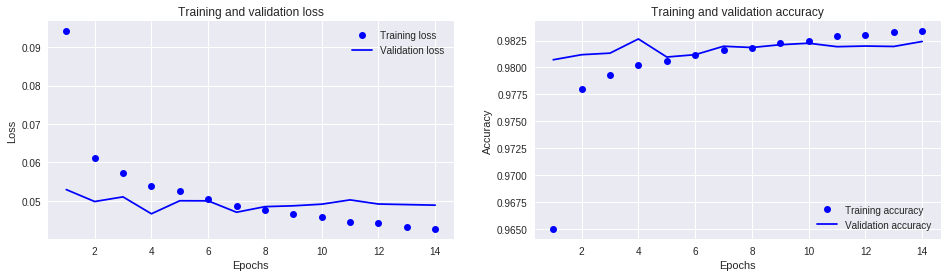

In [12]:
plot_history(history)

In [13]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 24s 748us/step
([0.04708621331655305, 0.9828189347187367], 0.9783129859996982)
